In [116]:
#Projet

## Question 1

**A. Monte-Carlo standard**

In [117]:
#!pip install qmcpy

In [141]:
import time
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats.qmc import Sobol

In [126]:
#Fonction target

def f(u):
    d = u.shape[1] 
    return 1 + np.sin(2 * np.pi * (1/d * np.sum(u, axis = 1) - 1/2))

In [145]:
#Estimation de l'intégrale par la méthode de Monte Carlo standard

def MonteCarlo(f,N,d):
    x = np.random.rand(N, d)
    integral = np.mean(f(x))
    return(integral)

In [146]:
MonteCarlo(f, N = 10000000, d = 3)

0.9996678243057265

**B. Quasi Monte-Carlo**

In [147]:
#Estimation de l'intégrale par la méthode de Quasi Monte Carlo 

def QuasiMonteCarlo(f, N, d):
    sobol = Sobol(d) #Génération des points quasi-aléatoires avec la méthode Sobol
    u = sobol.random(n=N) #Génération des points quasi-aléatoires
    integral = np.mean(f(u)) #Calcul de l'intégrale approximative
    return(integral)

QuasiMonteCarlo(f, N = 10000000, d = 3)

0.9999999493654588

**C. Comparaison**

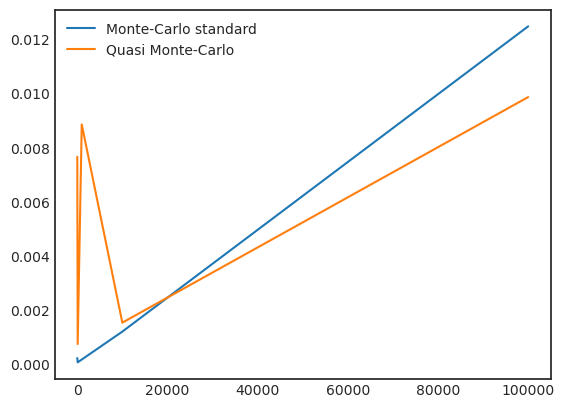

In [155]:
#Temps de calcul
NN = np.array([10, 100, 1000, 10000, 100000])

tempsMCstandard = []
tempsQMC = []

for n in NN :
    start_time = time.time()
    MonteCarlo(f, N = n, d = 3) #Appel de la fonction
    end_time = time.time()
    tempsMCstandard.append(end_time - start_time)
    
    start_time = time.time()
    QuasiMonteCarlo(f, N = n, d = 3) #Appel de la fonction
    end_time = time.time()
    tempsQMC.append(end_time - start_time)

plt.plot(NN,tempsMCstandard)
plt.plot(NN,tempsQMC)
plt.legend(['Monte-Carlo standard', 'Quasi Monte-Carlo'])


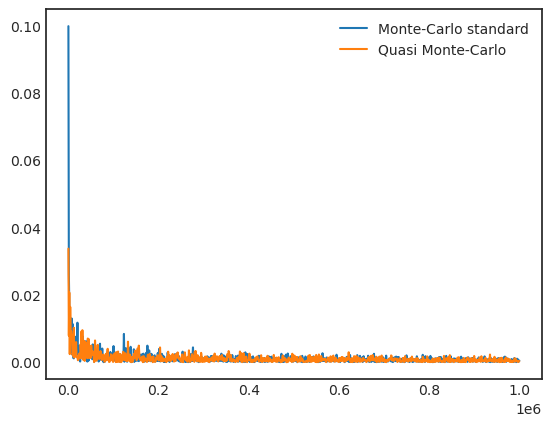

In [159]:
#Précision
NN = np.array([10, 100, 1000, 10000, 100000])
NN = np.arange(100, 1000000, 1000)

precisionMCstandard = []
precisionQMC = []

for n in NN :
    y_predict = MonteCarlo(f, N = n, d = 3) #Appel de la fonction
    precisionMCstandard.append(np.abs(1-y_predict))
    
    y_predict = MonteCarlo(f, N = n, d = 3) #Appel de la fonction
    precisionQMC.append(np.abs(1-y_predict))

plt.plot(NN,precisionMCstandard)
plt.plot(NN,precisionQMC)
plt.legend(['Monte-Carlo standard', 'Quasi Monte-Carlo'])

In [ ]:
#comparaisons à améliorer
#faire varier d et regarder la précision